<a href="https://colab.research.google.com/github/roulupen/EVAAssignments/blob/master/Assignment10/Assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Build GradCAM image on a random image using VGG model

In [1]:
from keras import backend as K
from vis.utils import utils
from keras import activations
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from skimage import io
from google.colab.patches import cv2_imshow
import numpy as np
import cv2

Using TensorFlow backend.


### Mount Google drive to load image

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Build the VGG16 network with ImageNet weights

In [3]:
model = VGG16(weights='imagenet', include_top=True)

W0710 16:35:20.391881 139904722032512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 16:35:20.441823 139904722032512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 16:35:20.450963 139904722032512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0710 16:35:20.511004 139904722032512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 12s 0us/step


W0710 16:35:33.742580 139904722032512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0710 16:35:33.744318 139904722032512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



### Swap softmax with linear layer

In [4]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
#layer_idx = utils.find_layer_idx(model, 'predictions')
#print(layer_idx)
layer_idx = -1

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


#### Model summary

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

#### Defining a function to apply Grad-CAM on a layer of VGG model by passing image path, model and layer name

In [0]:
def apply_grad_cam(image_path, model, grad_cam_layer):
  
  # Load image from image path
  if isinstance(image_path, str):
    img = io.imread(image_path)
  else:
    img = image_path
  
  # Rescale to 224x224(as per VGG model input size)
  img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  
  # Use expand_dims to convert image to a batch of size 1
  # Preprocesing normalizes our input image by subtracting mean RGB values
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  # We get the predictions for the image
  # We take the topmost class index
  # Take output from the final convolutional layer
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(grad_cam_layer)
  
  # Compute the gradient of the class output value with respect to the feature map
  # Pool the gradients over all the axies leaving out the channel dimension
  # Weigh the output feature map with the computed gradient values
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  
  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  # Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14
  # Normalize the heat map to make the values between 0 and 1
  heatmap = np.mean(conv_layer_output_value, axis = -1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  # Super impose heat map on the original image
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
  
  # Display image and the super imposed image
  #cv2_imshow(img)
  #cv2_imshow(superimposed_img)
  new_img = np.concatenate((img, superimposed_img), axis=1)
  cv2_imshow(new_img)
  
  
  

### Loading cifar10 dataset

In [7]:
from keras.datasets import cifar10
(train_X, train_Y), (test_X, test_Y) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


### Run Grad-CAM on cifar10 data on 4 random test images with VGG model at "block5_conv2"

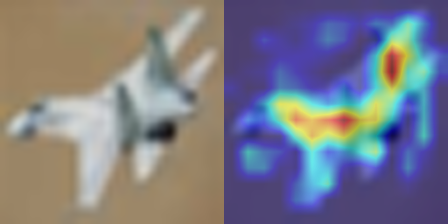

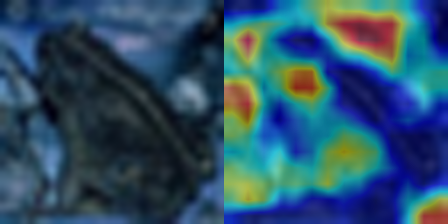

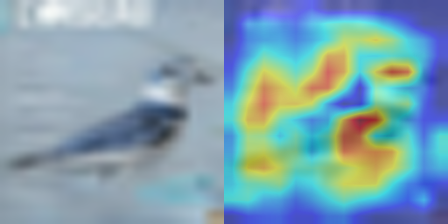

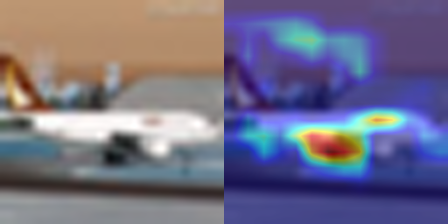

In [8]:
random_image_index = [10, 30, 70, 90]
for j in random_image_index:
  apply_grad_cam(test_X[j,:], model, "block5_conv2")

### Run Grad-CAM on cifar10 data on 4 random test images with VGG model at "block5_conv1"

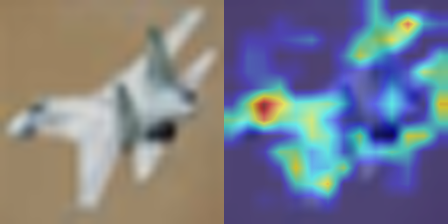

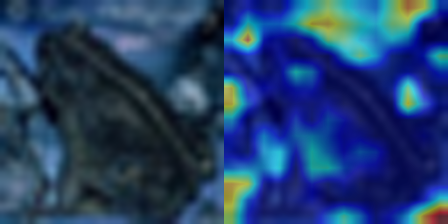

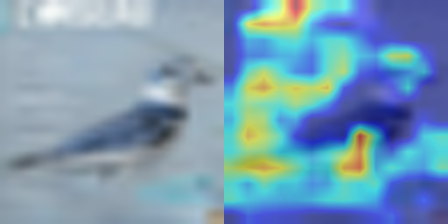

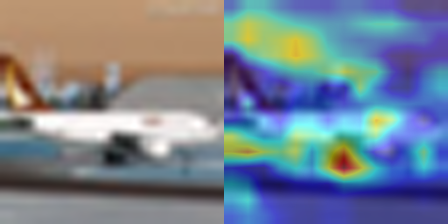

In [9]:
random_image_index = [10, 30, 70, 90]
for j in random_image_index:
  apply_grad_cam(test_X[j,:], model, "block5_conv1")

### Run the given image on same VGG model to display Grad-CAM output to indentify glasses.

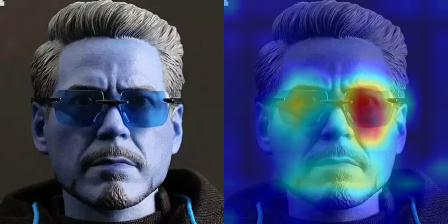

In [10]:
apply_grad_cam("/content/gdrive/My Drive/image1.png", model, "block5_conv3")

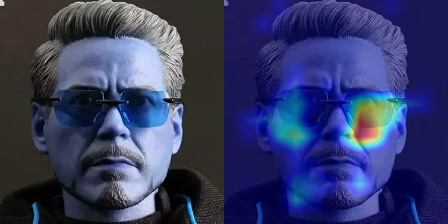

In [11]:
apply_grad_cam("/content/gdrive/My Drive/image1.png", model, "block5_conv2")

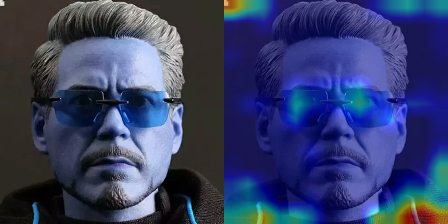

In [12]:
apply_grad_cam("/content/gdrive/My Drive/image1.png", model, "block5_conv1")

##### After running the Grad-CAM at different layers of convolution the Grad-CAM couldn't show the exact the glasses. So, I'm changing the softmax layer position 1 layer before final layer

In [13]:
new_model = VGG16(weights='imagenet', include_top=True)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = -2

# Swap softmax with linear
new_model.layers[layer_idx].activation = activations.linear
new_model = utils.apply_modifications(new_model)

new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


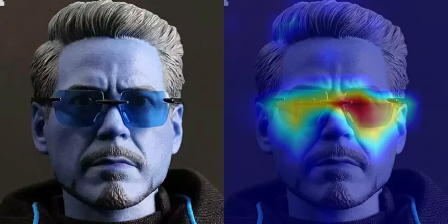

In [14]:
apply_grad_cam("/content/gdrive/My Drive/image1.png", new_model, "block5_conv2")

So, by positioning the softmax layer 1 layer before final prediction and using "block5_conv2" getting better result for identifying glasses. 

## Part -2 (RF Calculation)

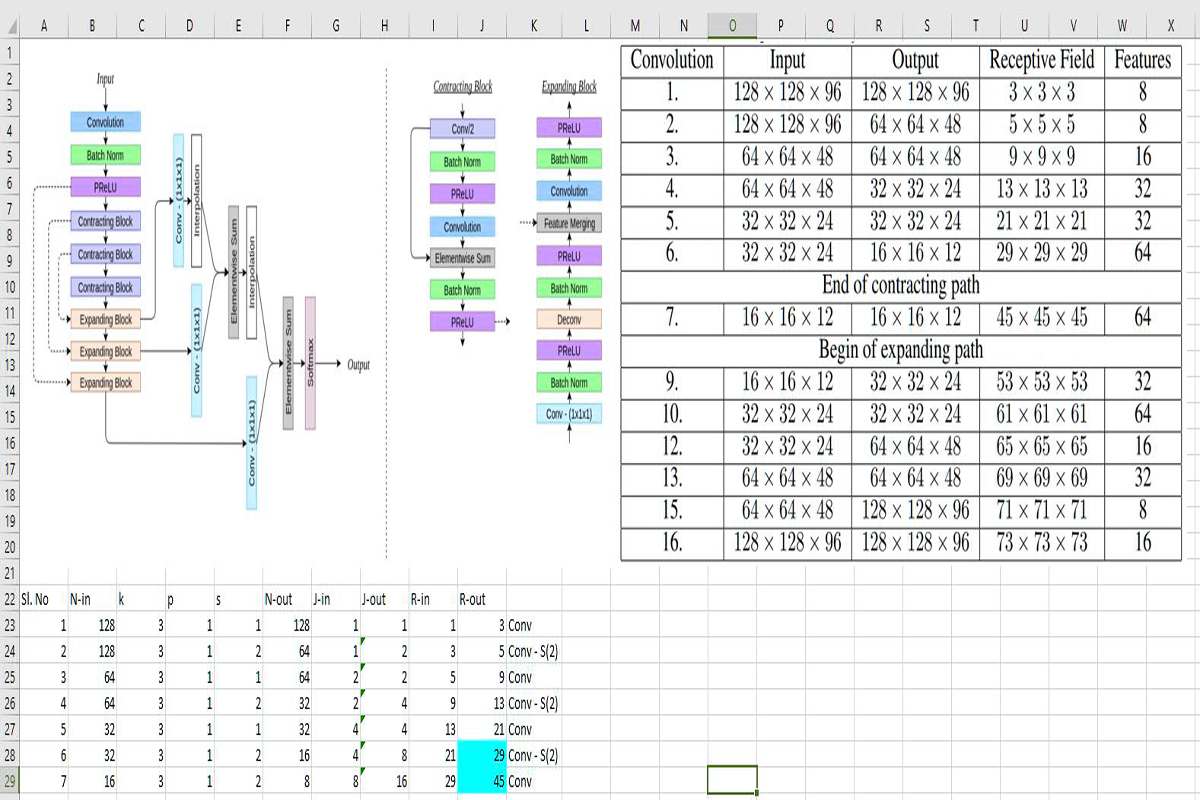

In [15]:
cv2_imshow(cv2.resize(io.imread("/content/gdrive/My Drive/RF Calculation -10.JPG"), dsize=(1200, 800), interpolation=cv2.INTER_CUBIC))